# Акустические модели

Акустическая модель - это часть системы автоматического распознавания речи, которая используется для преобразования аудиосигнала речи в последовательность фонем или других единиц речевого звука. Акустическая модель обучается на большом наборе речевых данных, чтобы определить, какие звуки соответствуют конкретным акустическим признакам в аудиосигнале. Эта модель может использоваться вместе с другими компонентами, такими как языковая модель и модель декодирования, чтобы достичь более точного распознавания речи.

В данной работе мы сконцентрируемся на обучении нейросетевых акустических моделей с помощью библиотек torch и torchaudio. Для экспериментов будем использовать базу [TIMIT](https://catalog.ldc.upenn.edu/LDC93s1)

In [1]:
import numpy as np
import time
import torch
import os
from typing import List, Dict, Union, Set, Any
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import soundfile as sf
import torchaudio
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


/home/karysheva@ad.speechpro.com/miniconda3/envs/ml_labs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Загрузка датасета TIMIT


Официальная страница датасета TIMIT

Для простоты загрузки данных удобнее всего пользоваться копией датасета, выложенной на kaggle

https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech


In [ ]:
!pip install kaggle

In [ ]:
# https://github.com/Kaggle/kaggle-api - Docs kaggle
# Simplest way: go to https://www.kaggle.com/settings , "Create new token" and move it into "~/.kaggle"

!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

Dataset URL: https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech
License(s): copyright-authors
100% 828M/829M [00:37<00:00, 23.9MB/s]
100% 829M/829M [00:37<00:00, 22.9MB/s]


In [ ]:
!unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

# 1. Подготовка данных для обучения

TIMIT является одной из самых широко используемых баз данных для изучения систем автоматического распознавания речи. База данных TIMIT содержит произнесения предложений различными дикторами. Каждое произнесение сопровождается его словной и фонетической разметкой.

Для обучения акустической модели нам в первую очередь интересна фонетическая разметка произнесений. Такая разметка сопоставляет фонемы, которые были произнесены диктором, с временными интервалами в записи. Такая разметка позволит нам обучить пофреймовый классификатор, который будет предсказывать сказанную фонему.

## 1.a. Загрузка базы с диска

In [2]:
class TimitDataset(Dataset):
    """Загрузка TIMIT данных с диска"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        self.uri2word_ali = {}
        self.uri2phone_ali = {}
        for d, _, fs in os.walk(data_path):
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.WAV'):
                    # skip it. Use .wav instead
                    pass
                elif f.endswith('.wav'):
                    stem = Path(f[:-4]).stem # .WAV.wav
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                elif f.endswith('.WRD'):
                    stem = Path(f).stem
                    self.uri2word_ali[f'{d}/{stem}'] = full_path
                elif f.endswith('.PHN'):
                    stem = Path(f).stem
                    self.uri2phone_ali[f'{d}/{stem}'] = full_path
                else:
                    warnings.warn(f"Unknown file type {full_path} . Skip it.")

        self.uris = list(sorted(set(self.uri2wav.keys()) \
                                & set(self.uri2text.keys()) \
                                & set(self.uri2word_ali.keys()) \
                                &  set(self.uri2phone_ali.keys())
                               ))
        print(f"Found {len(self.uris)} utterances in {self.data_path}. ",
              f"{len(self.uri2wav)} wavs, ",
              f"{len(self.uri2text)} texts, ",
              f"{len(self.uri2word_ali)} word alinments, ",
             f"{len(self.uri2phone_ali)} phone alignments")

    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri


    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr

    def get_text(self, index_or_uri: Union[str, int]):
        """ Return (start_sample, stop_sample, text)"""
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            start, stop, text = f.read().strip().split(maxsplit=2)
            start, stop = int(start), int(stop)
            assert start == 0, f"{txt_path}"
        return start, stop, text

    def get_word_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, word), ...]"""
        uri = self.get_uri(index_or_uri)
        wrd_path = self.uri2word_ali[uri]
        with open(wrd_path) as f:
            words = [(int(start), int(stop), word) for start, stop, word in map(str.split, f.readlines())]
        return words

    def get_phone_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, phone), ...]"""
        uri = self.get_uri(index_or_uri)
        ph_path = self.uri2phone_ali[uri]
        with open(ph_path) as f:
            phonemes = [(int(start), int(stop), ph) for start, stop, ph in map(str.split, f.readlines())]
        return phonemes

    def __getitem__(self, index):
        return {"uri": self.get_uri(index),
                "audio": self.get_audio(index),
                "text": self.get_text(index),
                "word_ali": self.get_word_ali(index),
                "phone_ali": self.get_phone_ali(index)}

    def __len__(self):
        # TODO
        # верните количество элементов в выборке
        return len(self.uris)

    def total_audio_samples(self) -> int:
        #TODO
        # верните суммарное количество отсчетов во всем аудио
        return sum(len(self.get_audio(uri)[0]) for uri in self.uris)

    def total_num_words(self) -> int:
        #TODO
        # верните суммарное количество слов в словном выравнивании
        return sum(len(self.get_word_ali(uri)) for uri in self.uris)

    def total_num_phones(self) -> int:
        #TODO
        # верните суммарное количество фонем в фонемном выравнивании
        return sum(len(self.get_phone_ali(uri)) for uri in self.uris)

    def get_vocab(self) -> Set[str]:
        #TODO
        # верните словарь, состоящий из уникальных слов из выборки
        return {word[2] for uri in self.uris for word in self.get_word_ali(uri)}

    def get_phones(self) -> Set[str]:
        #TODO
        # верните уникальный набор фонем, которые используются в выравнивании
        return {phone[2] for uri in self.uris for phone in self.get_phone_ali(uri)}

    def phones_prior(self) -> Dict[str, float]:
        #TODO
        # верните мапинг фонемы в их априорные вероятности.
        counts = Counter([phone[2] for uri in self.uris for phone in self.get_phone_ali(uri)])
        total = counts.total()
        priors = {key: value / total for key, value in dict(counts).items()}
        return priors


In [3]:
def test_timit_dataset_stats():
    test_ds = TimitDataset('timit/data/TEST/')

    print("Len")
    assert len(test_ds) == 1680, f"{len(test_ds)}"

    print("Audio")
    audio_len = test_ds.total_audio_samples()
    assert audio_len == 82986452, f"{audio_len}"

    print("Words")
    words_len = test_ds.total_num_words()
    assert words_len == 14553, f"{words_len}"

    print("Phones")
    phones_len = test_ds.total_num_phones()
    assert phones_len == 64145, f"{phones_len}"

    print("Vocab")
    vocab = test_ds.get_vocab()
    assert len(set(vocab)) == 2378, f"{len(set(vocab))}"

    print("Phones vocab")
    phones = test_ds.get_phones()
    assert len(set(phones)) == 61, f"{len(set(phones))}"

    print("Phones prior")
    priors = test_ds.phones_prior()
    assert np.isclose(sum(priors.values()), 1.0), f"sum(priors.values())"
    pmin, pmax = min(priors.keys(), key=priors.get), max(priors.keys(), key=priors.get)
    assert pmin == 'eng', pmin
    assert pmax == 'h#', pmax
    print("Test 1.a passed")
test_timit_dataset_stats()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Len
Audio
Words
Phones
Vocab
Phones vocab
Phones prior
Test 1.a passed


In [4]:
test_ds = TimitDataset('timit/data/TEST/')
item = test_ds[5]
print(item['uri'])
print(item['text'][2])
display.display(display.Audio(item['audio'][0].numpy(), rate=item['audio'][1]))
print('---words---')
for start, stop, word in item['word_ali']:
    print(word)
    display.display(display.Audio(item['audio'][0][start:stop].numpy(), rate=item['audio'][1]))
    break

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
timit/data/TEST/DR1/FAKS0/SX133
Pizzerias are convenient for a quick lunch.


---words---
pizzerias


## 1.b. Экстрактор фич
Для того чтобы построить акустическую модель, первым делом надо извлечь признаки аудио сигнала. Для распознавания речь принято использовать fbank признаки. fbank/MelSpectrogram признаки получается из амплитудного спектра сигнала путем свертки спекта с треугольными фильтрами в мел-шкале. Есть множество реализаций данных признаков в различных библиотеках (kaldi, librosa, torchaudio) и все они имеют свои особенности. В данной работе мы будем использовать реализацию из библиотеки torchaudio.

In [5]:
class FeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=40,
        f_max=7600,
        spec_aug_max_fmask=80,
        spec_aug_max_tmask=80,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.f_max = f_max
        self.spec_aug_max_fmask = spec_aug_max_fmask
        self.spec_aug_max_tmask = spec_aug_max_tmask
        #TODO
        # инициализируйте обработчик fbank фич из torchaudio
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            f_max=self.f_max
            )

        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=self.spec_aug_max_fmask)
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=self.spec_aug_max_tmask)

    def samples2frames(self, num_samples: int) -> int:
        # TODO
        # Верните количество кадров в спектрограмме, соответствующей вавке длиной num_samples
        return 1 + num_samples // self.hop_length

    @property
    def feats_dim(self):
        # TODO
        # Верните количество извлекаемых фич
        return self.n_mels

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        mel = self.mel_spec(waveform)
        mel = self.freq_mask(mel)
        mel = self.time_mask(mel)
        return mel

In [6]:
def test_samples2frames():
    fe = FeatureExtractor()
    for i in tqdm(range(15000, 40000)):
        wav = torch.zeros(i)
        feats = fe(wav)
        assert feats.shape[-2] == fe.feats_dim, f"{i} {feats.shape[-2]=}, {fe.feats_dim}"

        assert feats.shape[-1] == fe.samples2frames(i), f"{i} {feats.shape[-1]=}, {fe.samples2frames(i)}"

    print('Test 1.b passed')
test_samples2frames()

100%|██████████| 25000/25000 [00:14<00:00, 1730.01it/s]

Test 1.b passed


## 1.с. Таргеты и объединение данных в батчи

Акустическая Модель (АМ) - пофреймовый классификатор, который предсказывает фонему для каждого кадра аудио. Для обучения AM будем использовать фонемное выравнивание.

In [7]:
train_ds = TimitDataset('timit/data/TRAIN/')
print(train_ds[0])

# Строим мапинг из написания фонемы в ее id
phones = train_ds.get_phones()
phones.remove('pau')
phones.remove('epi')
phones.remove('h#')

# Фонемы паузы должны иметь индекс 0
PHONE2ID = {p:i for i, p in enumerate(['pau'] + list(sorted(phones)))}
PHONE2ID['epi'] = 0
PHONE2ID['h#'] = 0
print(PHONE2ID)

Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
{'uri': 'timit/data/TRAIN/DR1/FCJF0/SA1', 'audio': (tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -3.0518e-05,
        -1.5259e-04, -2.4414e-04]), 16000), 'text': (0, 46797, 'She had your dark suit in greasy wash water all year.'), 'word_ali': [(3050, 5723, 'she'), (5723, 10337, 'had'), (9190, 11517, 'your'), (11517, 16334, 'dark'), (16334, 21199, 'suit'), (21199, 22560, 'in'), (22560, 28064, 'greasy'), (28064, 33360, 'wash'), (33754, 37556, 'water'), (37556, 40313, 'all'), (40313, 44586, 'year')], 'phone_ali': [(0, 3050, 'h#'), (3050, 4559, 'sh'), (4559, 5723, 'ix'), (5723, 6642, 'hv'), (6642, 8772, 'eh'), (8772, 9190, 'dcl'), (9190, 10337, 'jh'), (10337, 11517, 'ih'), (11517, 12500, 'dcl'), (12500, 12640, 'd'), (12640, 14714, 'ah'), (14714, 15870, 'kcl'), (15870, 16334, 'k'), (16334, 18088, 's'), (18088, 20417, 'ux'), (20417, 21199, 'q'), (21199, 22560, 'en'), (225

In [8]:
class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id

    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']
        assert sr == self.feature_extractor.sample_rate, f"wrong sr for {index}"
        # подготавливаем пофреймовые фичи
        feats = self.feature_extractor(wav)
        feats = feats.squeeze(dim=0).transpose(0, 1) # time x feats

        # создаем пофреймовое выравнивание
        targets = torch.zeros(feats.shape[0], dtype=torch.long)
        # TODO
        # заполните пофреймовое фонемное выравнивание targets idшниками фонем
        # используйте phone_ali
        for start, end, phone in orig_item["phone_ali"]:
            start_frame = self.feature_extractor.samples2frames(start)
            end_frame = self.feature_extractor.samples2frames(end)
            phone_id = self.phone2id[phone]
            targets[start_frame:end_frame] = phone_id

        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets,
                "src_key_padding_mask": torch.zeros(feats.shape[0], dtype=torch.bool)}

    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        # TODO
        # Реализуйте функцию, которая объединяет несколько item'ов датасета в один батч
        # See collate_fn https://pytorch.org/docs/stable/data.html
        # Входные данные и маску надо вернуть таком формате, в каком работает с данными torch.nn.Transformer
        # targets надо склеить тензор с одной осью. Длина оси будет равна суммарному количеству кадров в батче
        max_length = max(item["feats"].shape[0] for item in batch)
        feats, targets, src_key_padding_mask = [], [], []

        for item in batch:
            length_to_pad = max_length - item["feats"].shape[0]
            feats.append(torch.cat([item["feats"], torch.zeros(length_to_pad, item["feats"].shape[1])]))
            targets.append(item["targets"])
            padding_mask = torch.cat([torch.zeros(item["feats"].shape[0], dtype=torch.bool), torch.ones(length_to_pad, dtype=torch.bool)])
            src_key_padding_mask.append(padding_mask)

        feats = torch.stack(feats).transpose(0, 1)
        targets = torch.cat(targets)
        src_key_padding_mask = torch.stack(src_key_padding_mask)

        return {'feats': feats, # (Time, Batch, feats)
               'targets': targets, #(SumTime)
               'src_key_padding_mask': src_key_padding_mask, #(Batch, Time)
               }


In [9]:
def test_collate_pad():
    fe = FeatureExtractor()
    test_ds = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)

    for i in range(20):
        targets = test_ds[i]['targets']
        orig_ph_ali = test_ds.get_phone_ali(i)
        targets_set = set(targets.tolist())
        orig_set = set([PHONE2ID[ph] for *_, ph in orig_ph_ali])
        assert targets_set == orig_set, f"{i} \n{targets_set} \n {orig_set} \n {orig_ph_ali}"

    items = [test_ds[i] for i in range(30)]
    batch = test_ds.collate_pad(items)
    assert len(batch['feats'].shape) == 3, batch['feats'].shape
    assert batch['feats'].shape[1] == 30, batch['feats'].shape

    assert len(batch['src_key_padding_mask'].shape) == 2, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[0] == 30, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[1] == batch['feats'].shape[0], f"{batch['feats'].shape} {batch['src_key_padding_mask'].shape}"

    number_nonmasked_frames = (~batch['src_key_padding_mask']).sum()
    assert number_nonmasked_frames == len(batch['targets']), f"{number_nonmasked_frames} != {len(batch['targets'])}"

    accumulated_len = 0
    for i, item in enumerate(items):
        feats = batch['feats'][:, i, :]
        assert torch.isclose(feats.sum(), item['feats'].sum()) , i
        src = batch['src_key_padding_mask'][i, :]
        cutted_feats = feats[~src]
        assert torch.isclose(item['feats'], cutted_feats).all()
        cutted_targets = batch['targets'][accumulated_len: accumulated_len + cutted_feats.shape[0]]
        assert torch.isclose(cutted_targets, item['targets']).all()
        accumulated_len += cutted_feats.shape[0]
    print("Test 1.c passed")

test_collate_pad()


Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Test 1.c passed


# 2. Акустическая модель

Обучим TransformerEncoder из torch решать задачу пофреймовой классификации.

In [10]:
class AModel(nn.Module):
    def __init__(self, feats_dim, out_dim,  dim=128, num_layers=4, ff_dim=256, dropout=0.1, nhead=4, max_len=780):
        super().__init__()
        self.feats_dim = feats_dim
        self.max_len=max_len
        self.input_ff = nn.Linear(feats_dim, dim)
        self.positional_encoding = nn.Embedding(max_len, dim)
        layer = torch.nn.TransformerEncoderLayer(d_model=dim,
                                                 nhead=nhead,
                                                 dim_feedforward=ff_dim,
                                                 dropout=dropout,
                                                 batch_first=False)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=layer, num_layers=num_layers)

        self.head = nn.Linear(dim, out_dim)

    def forward(self, feats, src_key_padding_mask=None, **kwargs):
        #TODO
        # реализуйте прямой проход модели.
        # Фичи подаются на первый ff слой,
        # к результату прибавляются позиционные эмбединги.
        # Далее фреймы обрабатываются трансформером
        # и финализируются с помощью головы
        x = self.input_ff(feats)
        # тензор с индексами позиций во входной последовательности
        positions = torch.arange(0, x.size(0), device=x.device).unsqueeze(1)
        positional_embeddings = self.positional_encoding(positions).expand(-1, x.size(1), -1)
        x = x + positional_embeddings
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        logits = self.head(x)

        return logits # (Time, Batch, Phones)

## 3. Обучение модели

In [11]:
# Стандартный пайплайн обучения моделей в pytorch
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.Adam, opt_kwargs={'lr':0.0001}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()

    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(**batch)
        # TODO
        # реализуйте подсчет loss функции
        mask = ~batch["src_key_padding_mask"].T
        masked_logits = logits[mask]
        loss = self.criterion(masked_logits, batch["targets"])
        return loss

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}

    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        # TODO
        # реализуйте функцию, которая подсчитывает лосс на валидационной выборке
        # losses должен хранить значение ошибки на каждом батче
        with torch.no_grad():
            for batch in pbar:
                loss = self.forward(batch)
                losses.append(loss.item())
                pbar.set_description(f"validation loss {losses[-1]:.5f}")
        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses

    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses)>0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()

/home/karysheva@ad.speechpro.com/miniconda3/envs/ml_labs/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Found 10 utterances in timit/data/TEST/DR1/FAKS0.  10 wavs,  10 texts,  10 word alinments,  10 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=256, bias=True)
  (positional_encoding): Embedding(780, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=256, out_features=59, bias=True)
).

training loss 4.19524: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


  1%|          | 1/160 [00:00<01:10,  2.25it/s]

train: 4.19524 | val: 3.98328


  1%|▏         | 2/160 [00:00<01:03,  2.48it/s]

train: 3.99013 | val: 3.82427


  2%|▏         | 3/160 [00:01<01:00,  2.61it/s]

train: 3.82472 | val: 3.75409


  2%|▎         | 4/160 [00:01<00:58,  2.68it/s]

train: 3.71927 | val: 3.69688


  3%|▎         | 5/160 [00:01<00:57,  2.70it/s]

train: 3.66752 | val: 3.66351


  4%|▍         | 6/160 [00:02<00:56,  2.70it/s]

train: 3.62004 | val: 3.61859


  4%|▍         | 7/160 [00:02<00:56,  2.72it/s]

train: 3.57859 | val: 3.57621


  5%|▌         | 8/160 [00:02<00:55,  2.74it/s]

train: 3.53023 | val: 3.55732


  6%|▌         | 9/160 [00:03<00:54,  2.75it/s]

train: 3.49236 | val: 3.53788


  6%|▋         | 10/160 [00:03<00:55,  2.72it/s]

train: 3.47777 | val: 3.52919


  7%|▋         | 11/160 [00:04<00:54,  2.72it/s]

train: 3.45482 | val: 3.52487


  8%|▊         | 12/160 [00:04<00:53,  2.75it/s]

train: 3.44321 | val: 3.50674


  8%|▊         | 13/160 [00:04<00:52,  2.78it/s]

train: 3.41903 | val: 3.49738


  9%|▉         | 14/160 [00:05<00:52,  2.79it/s]

train: 3.40415 | val: 3.48170


  9%|▉         | 15/160 [00:05<00:51,  2.82it/s]

train: 3.38832 | val: 3.46358


 10%|█         | 16/160 [00:05<00:50,  2.84it/s]

train: 3.36829 | val: 3.46058


 11%|█         | 17/160 [00:06<00:50,  2.82it/s]

train: 3.35435 | val: 3.46497


 11%|█▏        | 18/160 [00:06<00:51,  2.75it/s]

train: 3.34340 | val: 3.44827


 12%|█▏        | 19/160 [00:06<00:50,  2.80it/s]

train: 3.33104 | val: 3.45136


 12%|█▎        | 20/160 [00:07<00:49,  2.80it/s]

train: 3.31216 | val: 3.44066


 13%|█▎        | 21/160 [00:07<00:49,  2.81it/s]

train: 3.30165 | val: 3.45317


 14%|█▍        | 22/160 [00:07<00:48,  2.87it/s]

train: 3.29432 | val: 3.43705


 14%|█▍        | 23/160 [00:08<00:47,  2.89it/s]

train: 3.26395 | val: 3.44983


 15%|█▌        | 24/160 [00:08<00:47,  2.87it/s]

train: 3.23698 | val: 3.44883


 16%|█▌        | 25/160 [00:09<00:47,  2.85it/s]

train: 3.22402 | val: 3.44972


 16%|█▋        | 26/160 [00:09<00:46,  2.89it/s]

train: 3.21330 | val: 3.44790


 17%|█▋        | 27/160 [00:09<00:45,  2.89it/s]

train: 3.19375 | val: 3.45765


 18%|█▊        | 28/160 [00:10<00:45,  2.91it/s]

train: 3.17682 | val: 3.46212


 18%|█▊        | 29/160 [00:10<00:44,  2.92it/s]

train: 3.13669 | val: 3.46177


 19%|█▉        | 30/160 [00:10<00:45,  2.86it/s]

train: 3.10819 | val: 3.47636


 19%|█▉        | 31/160 [00:11<00:45,  2.85it/s]

train: 3.09623 | val: 3.48923


 20%|██        | 32/160 [00:11<00:44,  2.88it/s]

train: 3.06711 | val: 3.49278


 21%|██        | 33/160 [00:11<00:44,  2.86it/s]

train: 3.01516 | val: 3.50341


 21%|██▏       | 34/160 [00:12<00:44,  2.84it/s]

train: 2.99766 | val: 3.50606


 22%|██▏       | 35/160 [00:12<00:44,  2.80it/s]

train: 2.94951 | val: 3.50746


 22%|██▎       | 36/160 [00:12<00:44,  2.79it/s]

train: 2.90658 | val: 3.53038


 23%|██▎       | 37/160 [00:13<00:44,  2.79it/s]

train: 2.90120 | val: 3.55264


 24%|██▍       | 38/160 [00:13<00:43,  2.79it/s]

train: 2.91036 | val: 3.55656


 24%|██▍       | 39/160 [00:13<00:43,  2.77it/s]

train: 2.81968 | val: 3.55622


 25%|██▌       | 40/160 [00:14<00:43,  2.78it/s]

train: 2.84974 | val: 3.55912


 26%|██▌       | 41/160 [00:14<00:42,  2.83it/s]

train: 2.80561 | val: 3.58300


 26%|██▋       | 42/160 [00:15<00:41,  2.83it/s]

train: 2.68871 | val: 3.58957


 27%|██▋       | 43/160 [00:15<00:41,  2.82it/s]

train: 2.73473 | val: 3.60918


 28%|██▊       | 44/160 [00:15<00:41,  2.81it/s]

train: 2.61659 | val: 3.60658


 28%|██▊       | 45/160 [00:16<00:40,  2.84it/s]

train: 2.68038 | val: 3.63462


 29%|██▉       | 46/160 [00:16<00:39,  2.85it/s]

train: 2.57616 | val: 3.66497


 29%|██▉       | 47/160 [00:16<00:39,  2.87it/s]

train: 2.67723 | val: 3.65522


 30%|███       | 48/160 [00:17<00:39,  2.85it/s]

train: 2.58425 | val: 3.67445


 31%|███       | 49/160 [00:17<00:39,  2.84it/s]

train: 2.45774 | val: 3.70283


 31%|███▏      | 50/160 [00:17<00:38,  2.84it/s]

train: 2.42532 | val: 3.71376


 32%|███▏      | 51/160 [00:18<00:38,  2.83it/s]

train: 2.35914 | val: 3.73946


 32%|███▎      | 52/160 [00:18<00:38,  2.83it/s]

train: 2.39463 | val: 3.74419


 33%|███▎      | 53/160 [00:18<00:37,  2.84it/s]

train: 2.30246 | val: 3.77542


 34%|███▍      | 54/160 [00:19<00:37,  2.85it/s]

train: 2.26934 | val: 3.79436


 34%|███▍      | 55/160 [00:19<00:36,  2.85it/s]

train: 2.23392 | val: 3.81788


 35%|███▌      | 56/160 [00:19<00:36,  2.82it/s]

train: 2.18074 | val: 3.84051


 36%|███▌      | 57/160 [00:20<00:36,  2.82it/s]

train: 2.08632 | val: 3.86703


 36%|███▋      | 58/160 [00:20<00:36,  2.82it/s]

train: 2.12432 | val: 3.88494


 37%|███▋      | 59/160 [00:21<00:36,  2.80it/s]

train: 2.17207 | val: 3.90702


 38%|███▊      | 60/160 [00:21<00:35,  2.80it/s]

train: 1.99628 | val: 3.94587


 38%|███▊      | 61/160 [00:21<00:35,  2.77it/s]

train: 1.94357 | val: 3.99437


 39%|███▉      | 62/160 [00:22<00:35,  2.78it/s]

train: 1.97097 | val: 4.01798


 39%|███▉      | 63/160 [00:22<00:34,  2.80it/s]

train: 1.88202 | val: 4.03014


 40%|████      | 64/160 [00:22<00:33,  2.85it/s]

train: 1.81795 | val: 4.08353


 41%|████      | 65/160 [00:23<00:33,  2.82it/s]

train: 1.86624 | val: 4.12170


 41%|████▏     | 66/160 [00:23<00:32,  2.85it/s]

train: 1.86069 | val: 4.17132


 42%|████▏     | 67/160 [00:23<00:32,  2.86it/s]

train: 1.78351 | val: 4.19373


 42%|████▎     | 68/160 [00:24<00:32,  2.87it/s]

train: 1.68738 | val: 4.23680


 43%|████▎     | 69/160 [00:24<00:31,  2.89it/s]

train: 1.61902 | val: 4.25799


 44%|████▍     | 70/160 [00:24<00:31,  2.90it/s]

train: 1.66127 | val: 4.31657


 44%|████▍     | 71/160 [00:25<00:31,  2.86it/s]

train: 1.66669 | val: 4.34461


 45%|████▌     | 72/160 [00:25<00:32,  2.72it/s]

train: 1.59729 | val: 4.36096


 46%|████▌     | 73/160 [00:25<00:31,  2.78it/s]

train: 1.55325 | val: 4.40023


 46%|████▋     | 74/160 [00:26<00:30,  2.80it/s]

train: 1.50522 | val: 4.43812


 47%|████▋     | 75/160 [00:26<00:30,  2.82it/s]

train: 1.59360 | val: 4.44619


 48%|████▊     | 76/160 [00:27<00:29,  2.81it/s]

train: 1.45040 | val: 4.40227


 48%|████▊     | 77/160 [00:27<00:29,  2.83it/s]

train: 1.57261 | val: 4.51867


 49%|████▉     | 78/160 [00:27<00:28,  2.85it/s]

train: 1.39054 | val: 4.59577


 49%|████▉     | 79/160 [00:28<00:28,  2.83it/s]

train: 1.38830 | val: 4.57811


 50%|█████     | 80/160 [00:28<00:28,  2.84it/s]

train: 1.34273 | val: 4.62780


 51%|█████     | 81/160 [00:28<00:27,  2.86it/s]

train: 1.30733 | val: 4.65983


 51%|█████▏    | 82/160 [00:29<00:27,  2.87it/s]

train: 1.28286 | val: 4.72369


 52%|█████▏    | 83/160 [00:29<00:26,  2.86it/s]

train: 1.37329 | val: 4.71538


 52%|█████▎    | 84/160 [00:29<00:26,  2.87it/s]

train: 1.25671 | val: 4.67301


 53%|█████▎    | 85/160 [00:30<00:26,  2.82it/s]

train: 1.21023 | val: 4.69818


 54%|█████▍    | 86/160 [00:30<00:26,  2.80it/s]

train: 1.22165 | val: 4.78231


 54%|█████▍    | 87/160 [00:30<00:26,  2.80it/s]

train: 1.18891 | val: 4.86792


 55%|█████▌    | 88/160 [00:31<00:25,  2.81it/s]

train: 1.27480 | val: 4.89108


 56%|█████▌    | 89/160 [00:31<00:25,  2.83it/s]

train: 1.22875 | val: 4.88525


 56%|█████▋    | 90/160 [00:31<00:24,  2.86it/s]

train: 1.22868 | val: 4.85235


 57%|█████▋    | 91/160 [00:32<00:24,  2.87it/s]

train: 1.11165 | val: 4.90659


 57%|█████▊    | 92/160 [00:32<00:23,  2.88it/s]

train: 1.10707 | val: 4.95005


 58%|█████▊    | 93/160 [00:33<00:23,  2.86it/s]

train: 1.15420 | val: 4.93504


 59%|█████▉    | 94/160 [00:33<00:23,  2.83it/s]

train: 1.17256 | val: 5.03832


 59%|█████▉    | 95/160 [00:33<00:23,  2.81it/s]

train: 1.14016 | val: 5.08899


 60%|██████    | 96/160 [00:34<00:22,  2.81it/s]

train: 1.03978 | val: 5.04872


 61%|██████    | 97/160 [00:34<00:22,  2.82it/s]

train: 1.06840 | val: 5.09357


 61%|██████▏   | 98/160 [00:34<00:22,  2.81it/s]

train: 1.04429 | val: 5.09434


 62%|██████▏   | 99/160 [00:35<00:21,  2.82it/s]

train: 0.99934 | val: 5.10121


 62%|██████▎   | 100/160 [00:35<00:21,  2.82it/s]

train: 1.01236 | val: 5.20040


 63%|██████▎   | 101/160 [00:35<00:20,  2.83it/s]

train: 1.02345 | val: 5.16806


 64%|██████▍   | 102/160 [00:36<00:20,  2.86it/s]

train: 1.02589 | val: 5.18744


 64%|██████▍   | 103/160 [00:36<00:19,  2.87it/s]

train: 1.00900 | val: 5.27536


 65%|██████▌   | 104/160 [00:36<00:19,  2.86it/s]

train: 0.98089 | val: 5.21375


 66%|██████▌   | 105/160 [00:37<00:19,  2.85it/s]

train: 0.96217 | val: 5.30904


 66%|██████▋   | 106/160 [00:37<00:18,  2.85it/s]

train: 0.92375 | val: 5.27957


 67%|██████▋   | 107/160 [00:37<00:18,  2.82it/s]

train: 0.95049 | val: 5.28126


 68%|██████▊   | 108/160 [00:38<00:18,  2.81it/s]

train: 0.96059 | val: 5.26721


 68%|██████▊   | 109/160 [00:38<00:18,  2.80it/s]

train: 0.90567 | val: 5.31852


 69%|██████▉   | 110/160 [00:39<00:17,  2.82it/s]

train: 0.88614 | val: 5.33216


 69%|██████▉   | 111/160 [00:39<00:17,  2.81it/s]

train: 0.85837 | val: 5.44656


 70%|███████   | 112/160 [00:39<00:17,  2.79it/s]

train: 0.86551 | val: 5.41474


 71%|███████   | 113/160 [00:40<00:16,  2.79it/s]

train: 0.86923 | val: 5.46222


 71%|███████▏  | 114/160 [00:40<00:16,  2.81it/s]

train: 0.91363 | val: 5.42509


 72%|███████▏  | 115/160 [00:40<00:15,  2.83it/s]

train: 0.85930 | val: 5.43285


 72%|███████▎  | 116/160 [00:41<00:15,  2.79it/s]

train: 0.84962 | val: 5.38848


 73%|███████▎  | 117/160 [00:41<00:15,  2.80it/s]

train: 0.81290 | val: 5.43375


 74%|███████▍  | 118/160 [00:41<00:14,  2.81it/s]

train: 0.80781 | val: 5.54020


 74%|███████▍  | 119/160 [00:42<00:14,  2.80it/s]

train: 0.82951 | val: 5.51800


 75%|███████▌  | 120/160 [00:42<00:14,  2.84it/s]

train: 0.80583 | val: 5.54139


 76%|███████▌  | 121/160 [00:42<00:13,  2.84it/s]

train: 0.81216 | val: 5.55613


 76%|███████▋  | 122/160 [00:43<00:13,  2.84it/s]

train: 0.79849 | val: 5.60907


 77%|███████▋  | 123/160 [00:43<00:13,  2.84it/s]

train: 0.80785 | val: 5.64022


 78%|███████▊  | 124/160 [00:44<00:12,  2.83it/s]

train: 0.81441 | val: 5.65181


 78%|███████▊  | 125/160 [00:44<00:12,  2.83it/s]

train: 0.79675 | val: 5.60109


 79%|███████▉  | 126/160 [00:44<00:13,  2.51it/s]

train: 0.75721 | val: 5.67075


 79%|███████▉  | 127/160 [00:45<00:12,  2.60it/s]

train: 0.76573 | val: 5.61044


 80%|████████  | 128/160 [00:45<00:11,  2.67it/s]

train: 0.74354 | val: 5.58148


 81%|████████  | 129/160 [00:45<00:11,  2.72it/s]

train: 0.73779 | val: 5.69192


 81%|████████▏ | 130/160 [00:46<00:10,  2.75it/s]

train: 0.74952 | val: 5.62024


 82%|████████▏ | 131/160 [00:46<00:10,  2.77it/s]

train: 0.75346 | val: 5.66475


 82%|████████▎ | 132/160 [00:46<00:10,  2.75it/s]

train: 0.71627 | val: 5.74862


 83%|████████▎ | 133/160 [00:47<00:09,  2.76it/s]

train: 0.77520 | val: 5.73621


 84%|████████▍ | 134/160 [00:47<00:09,  2.78it/s]

train: 0.72387 | val: 5.73035


 84%|████████▍ | 135/160 [00:48<00:08,  2.79it/s]

train: 0.71478 | val: 5.80921


 85%|████████▌ | 136/160 [00:48<00:08,  2.81it/s]

train: 0.71475 | val: 5.86991


 86%|████████▌ | 137/160 [00:48<00:08,  2.82it/s]

train: 0.72042 | val: 5.75330


 86%|████████▋ | 138/160 [00:49<00:07,  2.84it/s]

train: 0.69929 | val: 5.86771


 87%|████████▋ | 139/160 [00:49<00:07,  2.84it/s]

train: 0.69688 | val: 5.78049


 88%|████████▊ | 140/160 [00:49<00:07,  2.85it/s]

train: 0.70643 | val: 5.78460


 88%|████████▊ | 141/160 [00:50<00:06,  2.85it/s]

train: 0.66994 | val: 5.87009


 89%|████████▉ | 142/160 [00:50<00:06,  2.83it/s]

train: 0.67219 | val: 5.88686


 89%|████████▉ | 143/160 [00:50<00:06,  2.83it/s]

train: 0.69284 | val: 5.85977


 90%|█████████ | 144/160 [00:51<00:05,  2.82it/s]

train: 0.68522 | val: 5.88549


 91%|█████████ | 145/160 [00:51<00:05,  2.82it/s]

train: 0.65296 | val: 5.92479


 91%|█████████▏| 146/160 [00:51<00:04,  2.82it/s]

train: 0.66451 | val: 5.93018


 92%|█████████▏| 147/160 [00:52<00:04,  2.81it/s]

train: 0.65239 | val: 5.99008


 92%|█████████▎| 148/160 [00:52<00:04,  2.81it/s]

train: 0.65500 | val: 6.01957


 93%|█████████▎| 149/160 [00:53<00:03,  2.82it/s]

train: 0.67110 | val: 6.04543


 94%|█████████▍| 150/160 [00:53<00:03,  2.81it/s]

train: 0.63195 | val: 5.96204


 94%|█████████▍| 151/160 [00:53<00:03,  2.81it/s]

train: 0.65204 | val: 5.89424


 95%|█████████▌| 152/160 [00:54<00:02,  2.82it/s]

train: 0.67181 | val: 5.98975


 96%|█████████▌| 153/160 [00:54<00:02,  2.83it/s]

train: 0.60859 | val: 6.04173


 96%|█████████▋| 154/160 [00:54<00:02,  2.83it/s]

train: 0.62993 | val: 6.06847


 97%|█████████▋| 155/160 [00:55<00:01,  2.81it/s]

train: 0.61561 | val: 6.08622


 98%|█████████▊| 156/160 [00:55<00:01,  2.83it/s]

train: 0.62824 | val: 6.13555


 98%|█████████▊| 157/160 [00:55<00:01,  2.84it/s]

train: 0.59754 | val: 6.11789


 99%|█████████▉| 158/160 [00:56<00:00,  2.85it/s]

train: 0.63761 | val: 6.10613


 99%|█████████▉| 159/160 [00:56<00:00,  2.69it/s]

train: 0.60775 | val: 6.15732


100%|██████████| 160/160 [00:56<00:00,  2.81it/s]


train: 0.60132 | val: 6.09250


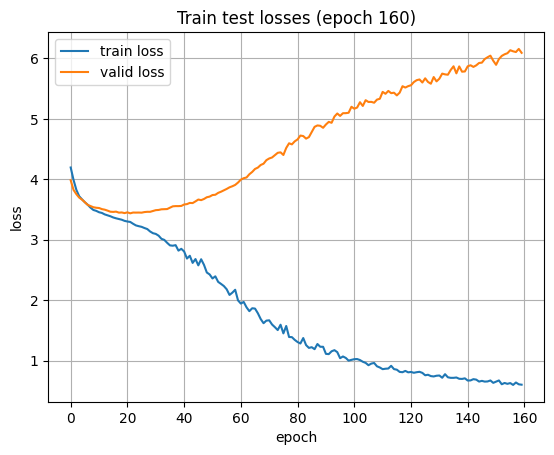

validation loss 6.03964: 100%|██████████| 10/10 [00:00<00:00, 63.03it/s]


AssertionError: 6.163212299346924. Model doesn't train well

In [37]:
def overfit_one_batch_check():
    # Для проверки работоспособности кода обучения удоно использовать тест модели на overfit
    # Для этого запускается обучение на одном батче данных.
    # Если код написан правильно, то модель обязана выучить выучить все примеры из этого батча наизусть.
    fe = FeatureExtractor()
    train_dataset = FeatsPhoneDataset('timit/data/TEST/DR1/FAKS0', feature_extractor=fe, phone2id=PHONE2ID)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_pad)
    test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate_pad)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim,
                                   out_dim=max(PHONE2ID.values()) + 1,
                                   dim=256,
                                   num_layers=6,
                                   ff_dim=512,
                                   dropout=0.0,
                                   nhead=8),
                      fe=fe,
                      phone2id=PHONE2ID, device='cuda')

    # only one batch. The model must learn it by heart
    losses, val_losses = trainer.fit(train_dataloader, 160, valid_dataloader=test_dataloader, plot_losses=False)

    trainer.plot_losses(losses, val_losses)

    val_loss = np.mean(trainer.score(test_dataloader))

    assert val_loss < 0.5, f"{val_loss}. Model doesn't train well"
    print(f"Test 3.a passed")
overfit_one_batch_check()

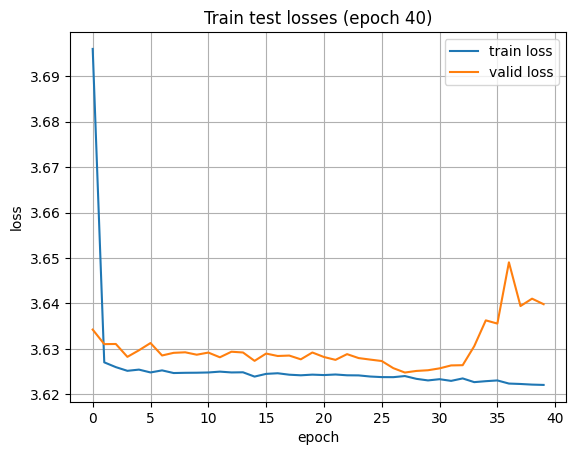

In [ ]:

def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=40,
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)


    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim,
                                 out_dim=max(PHONE2ID.values())+1,
                                 dim=128,
                                 num_layers=7,
                                 ff_dim=256,
                                 dropout=0.0,
                                 nhead=8),
                     fe=fe,
                     phone2id=PHONE2ID, device='cuda')

    trainer.fit(train_dataloader, epochs=40, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu')
results = experiment()

In [ ]:
torch.save(results, 'baseline.trainer')

# Основное задание (12 баллов)
Надо улучшить бейзлайн так, чтобы значение loss на валидации было менее 1.9

**Дополнительное задание** (4 балла): Улучшите loss до 1.4

In [12]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

In [13]:
class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id

    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']

        feats = self.feature_extractor(wav, return_tensors="pt", sampling_rate=sr)['input_values']
        feats = feats.transpose(0, 1)
        
        out_dim = len(wav) // 320  # wav2vec2 обрабатывает блоки в 320 сэмплов
        targets = torch.zeros(out_dim, dtype=torch.long)
        scale = len(wav) / out_dim  # столько сэмплов приходится на один шаг выходной последовательности 
        
        for phone in orig_item["phone_ali"]:
            start = int(phone[0] / scale)
            end = int(phone[1] / scale)
            targets[start:end] = self.phone2id[phone[2]]
        
        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets, 
                "src_key_padding_mask": torch.zeros(out_dim, dtype=torch.bool)}


    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        # TODO
        # Реализуйте функцию, которая объединяет несколько item'ов датасета в один батч
        # See collate_fn https://pytorch.org/docs/stable/data.html
        # Входные данные и маску надо вернуть таком формате, в каком работает с данными torch.nn.Transformer
        # targets надо склеить тензор с одной осью. Длина оси будет равна суммарному количеству кадров в батче
        max_length = max(item["feats"].shape[0] for item in batch)
        feats, targets, src_key_padding_mask = [], [], []

        for item in batch:
            length_to_pad = max_length - item["feats"].shape[0]
            feats.append(torch.cat([item["feats"], torch.zeros(length_to_pad, item["feats"].shape[1])]))
            targets.append(item["targets"])
            padding_mask = torch.cat([torch.zeros(item["feats"].shape[0], dtype=torch.bool), torch.ones(length_to_pad, dtype=torch.bool)])
            src_key_padding_mask.append(padding_mask)

        feats = torch.stack(feats).transpose(0, 1)
        targets = torch.cat(targets)
        src_key_padding_mask = torch.stack(src_key_padding_mask)

        return {'feats': feats, # (Time, Batch, feats)
               'targets': targets, #(SumTime)
               'src_key_padding_mask': src_key_padding_mask, #(Batch, Time)
               }


In [19]:
class Wav2Vec2BasedModel(nn.Module):
    def __init__(self, model_name, out_dim):
        super(Wav2Vec2BasedModel, self).__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(model_name)
        self.linear = nn.Linear(in_features=768, out_features=out_dim)
    
    def forward(self, feats):
        feats = feats.squeeze(dim=-1).transpose(0, 1)
        features = self.wav2vec2(feats).last_hidden_state
        output = self.linear(features)
        
        return output

In [ ]:
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.AdamW, opt_kwargs={'lr':0.0001}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()

    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(batch["feats"])
        # TODO
        # реализуйте подсчет loss функции
        mask = ~batch["src_key_padding_mask"][:, :logits.shape[1]]
        targets = batch["targets"][:logits.shape[1]]
        loss = self.criterion(logits[mask], targets)
        return loss

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}

    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        # TODO
        # реализуйте функцию, которая подсчитывает лосс на валидационной выборке
        # losses должен хранить значение ошибки на каждом батче
        with torch.no_grad():
            for batch in pbar:
                loss = self.forward(batch)
                losses.append(loss.item())
                pbar.set_description(f"validation loss {losses[-1]:.5f}")
        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses
    
    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses)>0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()

In [25]:
model_name = "OthmaneJ/distil-wav2vec2"

In [26]:
def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, 
                                               num_workers=4, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=4, collate_fn=test_dataset.collate_pad, shuffle=False)

    trainer = Trainer(model=Wav2Vec2BasedModel(model_name=model_name,
                                               out_dim=max(PHONE2ID.values()) + 1),
                     fe=fe,
                     phone2id=PHONE2ID, device='cuda')
    trainer.fit(train_dataloader, epochs=5, valid_dataloader=test_dataloader, plot_losses=True)

    return trainer.to('cpu')

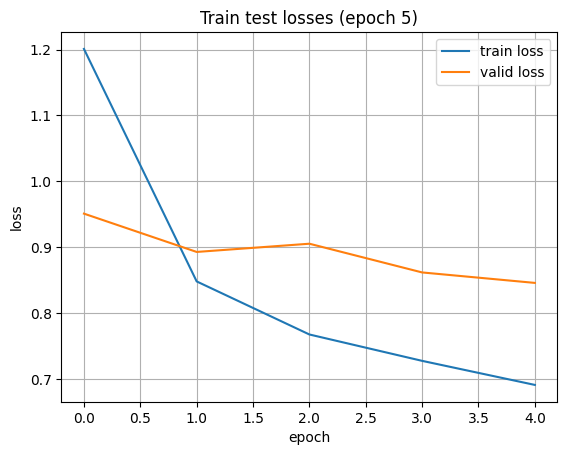

100%|██████████| 5/5 [18:45<00:00, 225.16s/it]


In [27]:
wav2vec2_results = experiment()

In [31]:
wav2vec2_results

Trainer(
  (model): Wav2Vec2BasedModel(
    (wav2vec2): Wav2Vec2Model(
      (feature_extractor): Wav2Vec2FeatureEncoder(
        (conv_layers): ModuleList(
          (0): Wav2Vec2GroupNormConvLayer(
            (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
            (activation): GELUActivation()
            (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
          )
          (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
          (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
            (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
            (activation): GELUActivation()
          )
        )
      )
      (feature_projection): Wav2Vec2FeatureProjection(
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (projection): Linear(in_features=512, out_features=768, bias=True)


In [33]:
def save_trainer(trainer, path):
    torch.save({
        'model_state_dict': trainer.model.state_dict(),
        'optimizer_state_dict': trainer.optimizer.state_dict() if trainer.optimizer else None,
        'feature_extractor': trainer.fe,
        'phone2id': trainer.phone2id
    }, path)

In [34]:
save_trainer(wav2vec2_results, 'wav2vec2.trainer')

In [28]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.8, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.3:
        print(f"Additional task is done! (+4 points)")
test_trained_model(wav2vec2_results.to('cuda'))

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments


validation loss 0.51093:   0%|          | 4/1680 [00:00<00:41, 39.96it/s]

validation loss 1.26457: 100%|██████████| 1680/1680 [00:36<00:00, 45.55it/s]

Test loss is 0.8597132013135013
Main task is done! (12 points)
Additional task is done! (+4 points)
